In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER,LATITUDE_FORMATTER
import os,errno
import sys
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import pandas as pd
import datetime as dt
from scipy.ndimage.measurements import label
from math import sin, cos, sqrt, atan2, radians
import geopy.distance
%matplotlib inline

dir2='/thorncroftlab_rit/ahenny/rain/'
dir1='/thorncroftlab_rit/ahenny/rain/US/ghcnd_all/'
dir='/thorncroftlab_rit/ahenny/rain/DISSERTATION_SCRIPTS_RESULTS/'
#This script plots trends (and means) in large-scale atmospheric variables in Mei-yu season

In [ ]:
ds=xr.open_dataset(dir+'era_5_mys_mslp_taiwan.nc')
slp1=ds['msl']
print(slp1)

In [4]:
ds1=xr.open_dataset(dir+'era_5_mys_ivtx_taiwan.nc')
ivtx=ds1['p71.162']

ds2=xr.open_dataset(dir+'era_5_mys_ivty_taiwan.nc')
ivty=ds2['p72.162']

In [ ]:
print(ivtx)

In [ ]:
for i in range(41):
    print(1979+i)
    date_start=dt.datetime(1979+i,5,14,18)
    date_range=[date_start+dt.timedelta(hours=6*x) for x in range(47*4)]
    date_range=pd.DatetimeIndex(date_range)
    slp_year=slp1.sel(time=date_range)
    slp_mean=slp_year.mean(dim='time',skipna=True)
    
    ivtx_year=ivtx.sel(time=date_range)
    ivty_year=ivty.sel(time=date_range)
    ivtx_mean=ivtx_year.mean(dim='time',skipna=True)
    ivty_mean=ivty_year.mean(dim='time',skipna=True)
    
    if i==0:
        slp_annual_mean=slp_mean
        ivtx_annual_mean=ivtx_mean
        ivty_annual_mean=ivty_mean
    else:
        slp_annual_mean=xr.concat([slp_annual_mean,slp_mean],dim='time')
        ivtx_annual_mean=xr.concat([ivtx_annual_mean,ivtx_mean],dim='time')
        ivty_annual_mean=xr.concat([ivty_annual_mean,ivty_mean],dim='time')

In [8]:
#@author: Michael Schramm on GitHub
#This function is derived from code originally posted by Sat Kumar Tomer
#(satkumartomer@gmail.com)
#See also: http://vsp.pnnl.gov/help/Vsample/Design_Trend_Mann_Kendall.htm
from scipy.stats import norm
import scipy.stats as st
def mk_test(x, alpha=0.05):
    n = len(x)

    # calculate S
    s = 0
    for k in range(n-1):
        for j in range(k+1, n):
            s += np.sign(x[j] - x[k])

    # calculate the unique data
    unique_x, tp = np.unique(x, return_counts=True)
    g = len(unique_x)

    # calculate the var(s)
    if n == g:  # there is no tie
        var_s = (n*(n-1)*(2*n+5))/18
    else:  # there are some ties in data
        var_s = (n*(n-1)*(2*n+5) - np.sum(tp*(tp-1)*(2*tp+5)))/18

    if s > 0:
        z = (s - 1)/np.sqrt(var_s)
    elif s < 0:
        z = (s + 1)/np.sqrt(var_s)
    else: # s == 0:
        z = 0

    # calculate the p_value
    p = 2*(1-norm.cdf(abs(z)))  # two tail test
    h = abs(z) > norm.ppf(1-alpha/2)

    if (z < 0) and h:
        trend = 'decreasing'
    elif (z > 0) and h:
        trend = 'increasing'
    else:
        trend = 'no trend'

    return trend, h, p, z

In [ ]:
slp_annual_mean=slp_annual_mean/100.
print(slp_annual_mean.max().values)

In [ ]:
slopes_array_slp=xr.zeros_like(slp1[0,:,:])
sigs_array_slp=xr.zeros_like(slp1[0,:,:])
sigs_array_slp_10=xr.zeros_like(slp1[0,:,:])

slopes_array_ivtx=xr.zeros_like(slp1[0,:,:])
sigs_array_ivtx=xr.zeros_like(slp1[0,:,:])
sigs_array_ivtx_10=xr.zeros_like(slp1[0,:,:])

slopes_array_ivty=xr.zeros_like(slp1[0,:,:])
sigs_array_ivty=xr.zeros_like(slp1[0,:,:])
sigs_array_ivty_10=xr.zeros_like(slp1[0,:,:])
for i in range(slp1.latitude.size):
    print(i)
    for j in range(slp1.longitude.size):
        time_series=slp_annual_mean[:,i,j].values.tolist()
        linreg=st.linregress(np.arange(1979,2020,1),time_series)
        slope=linreg[0]
        p_value=linreg[3]
        mk_result_slp=mk_test(time_series,alpha=0.05)[0]
        mk_result_slp1=mk_test(time_series,alpha=0.10)[0]
        slopes_array_slp[i,j]=slope
        if mk_result_slp in ['increasing','decreasing']:
            sigs_array_slp[i,j]=1
        if mk_result_slp1 in ['increasing','decreasing']:
            sigs_array_slp_10[i,j]=1
            
        time_series=ivtx_annual_mean[:,i,j].values.tolist()
        linreg=st.linregress(np.arange(1979,2020,1),time_series)
        slope=linreg[0]
        p_value=linreg[3]
        mk_result_ivtx=mk_test(time_series,alpha=0.05)[0]
        mk_result_ivtx1=mk_test(time_series,alpha=0.10)[0]
        slopes_array_ivtx[i,j]=slope
        if mk_result_ivtx in ['increasing','decreasing']:
            sigs_array_ivtx[i,j]=1
        if mk_result_ivtx1 in ['increasing','decreasing']:
            sigs_array_ivtx_10[i,j]=1
            
        time_series=ivty_annual_mean[:,i,j].values.tolist()
        linreg=st.linregress(np.arange(1979,2020,1),time_series)
        slope=linreg[0]
        p_value=linreg[3]
        mk_result_ivty=mk_test(time_series,alpha=0.05)[0]
        mk_result_ivty1=mk_test(time_series,alpha=0.10)[0]
        slopes_array_ivty[i,j]=slope
        if mk_result_ivty in ['increasing','decreasing']:
            sigs_array_ivty[i,j]=1
        if mk_result_ivty1 in ['increasing','decreasing']:
            sigs_array_ivty_10[i,j]=1

In [ ]:
mslp_mean_all=slp1.mean(dim='time',skipna=True)
print(mslp_mean_all)
print(slopes_array_zombie)

array_first=mslp_mean_all[:,-400:]
array_second=mslp_mean_all[:,0:400]
array_second['longitude']=array_second.longitude.values+360.
array_zombie=xr.concat([array_first,array_second],dim='longitude')
print(array_zombie)

In [ ]:
print(array_zombie.min().values)
print(array_zombie.max().values)

In [ ]:
proj_map = ccrs.PlateCarree(central_longitude=180)
fig = plt.figure(figsize=(24,8))
ax=plt.subplot(1,1,1,projection=proj_map)

first=slopes_array_slp[:,0]
last=slopes_array_slp[:,-1]

slopes_array_first=slopes_array_slp[:,-400:]
slopes_array_second=slopes_array_slp[:,0:400]
slopes_array_second['longitude']=slopes_array_second.longitude.values+360.
slopes_array_zombie=xr.concat([slopes_array_first,slopes_array_second],dim='longitude')

cax=ax.contourf(slopes_array_zombie.longitude,slopes_array_zombie.latitude,slopes_array_zombie,transform=ccrs.PlateCarree(),levels=np.arange(-0.07,0.075,0.005),extend='both',cmap=plt.cm.seismic_r)
cbar=plt.colorbar(cax,pad=0,fraction=0.042)
cbar.ax.tick_params(labelsize=22) 
cbar.set_label('hPa/year',fontsize=22,rotation=90,labelpad=12)
cbar.ax.tick_params(labelsize=20)  
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.STATES.with_scale('10m'),alpha=0.3)
ax.add_feature(cfeature.LAKES.with_scale('50m'))
countries = cfeature.NaturalEarthFeature(category='cultural',name='admin_0_boundary_lines_land',scale='50m',facecolor='none')
ax.add_feature(countries)
    
latmin=0
latmax=40
lonmin=90
lonmax=200
print((lonmin,lonmax))
print((latmin,latmax))
#ax.set_xlim(lonmin,lonmax)
#ax.set_ylim(latmin,latmax)
#ax.set_extent([90,-120,0,40])
ax.set_extent([90, 240, 0, 58], crs=ccrs.PlateCarree())
ax.set_title('Mei-Yu season MSLP and IVT trends',fontsize=36)

Y=5
X=8
if 1==1:
    for i in range(int(slopes_array_slp.longitude.size/Y)):
        for j in range(int(slopes_array_slp.latitude.size/Y)):
            if sigs_array_slp[Y*j,Y*i]==1:
                ax.plot(slopes_array_slp.longitude.values[Y*i],slopes_array_slp.latitude.values[Y*j],transform=ccrs.PlateCarree(),marker='o',color='w',mew=1.75,markersize=6,markerfacecolor="None")
            else:
                if sigs_array_slp_10[Y*j,Y*i]==1:
                    if slopes_array_slp[Y*j,Y*i]>0:
                        ax.plot(slopes_array_slp.longitude.values[Y*i],slopes_array_slp.latitude.values[Y*j],transform=ccrs.PlateCarree(),marker='o',color='w',mew=0.5,markersize=6,markerfacecolor="None")
                    if slopes_array_slp[Y*j,Y*i]<0:
                        ax.plot(slopes_array_slp.longitude.values[Y*i],slopes_array_slp.latitude.values[Y*j],transform=ccrs.PlateCarree(),marker='o',color='w',mew=0.5,markersize=6,markerfacecolor="None")

print(slopes_array_zombie)
print(array_zombie)   
c=ax.contour(array_zombie.longitude,array_zombie.latitude,array_zombie/100.,transform=ccrs.PlateCarree(),levels=np.arange(992,1032,2),colors='k',linewidths=0.5,alpha=0.5)
plt.clabel(c,fmt='%.00f',fontsize=15)

sig_xy=sigs_array_ivtx+sigs_array_ivty
sig_xy10=sigs_array_ivtx_10+sigs_array_ivty_10
slopes_array_ivtx_select=slopes_array_ivtx.where(sig_xy>0)
slopes_array_ivty_select=slopes_array_ivty.where(sig_xy>0)

slopes_array_ivtx_select10=slopes_array_ivtx.where(sig_xy10>0)
slopes_array_ivty_select10=slopes_array_ivty.where(sig_xy10>0)

q0=ax.quiver(ivtx.longitude[0::X].values,ivtx.latitude[0::X].values,slopes_array_ivtx_select10[0::X,0::X].values,slopes_array_ivty_select10[0::X,0::X].values,transform=ccrs.PlateCarree(),units='inches',scale=4,width=0.019,alpha=0.35)
q=ax.quiver(ivtx.longitude[0::X].values,ivtx.latitude[0::X].values,slopes_array_ivtx_select[0::X,0::X].values,slopes_array_ivty_select[0::X,0::X].values,transform=ccrs.PlateCarree(),units='inches',scale=4,width=0.019,alpha=0.85)
ax.quiverkey(q,0.94,1.01,1,'1 kg/m/s',fontproperties={'size':16})



xticks = [100,120,140,160,180,-160,-140,-120]
yticks = [5, 15, 25, 35, 45, 55]
ax.tick_params(labelsize=22)

g1=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1.5,color='gray',alpha=0.0,linestyle='--')
cbar.ax.tick_params(labelsize=16) 
g1.xlabel_style={'size':22,'color':'k'}
g1.ylabel_style={'size':22,'color':'k'}
g1.xformatter=LONGITUDE_FORMATTER
g1.yformatter=LATITUDE_FORMATTER
g1.xlocator = mticker.FixedLocator(xticks)
g1.ylocator = mticker.FixedLocator(yticks)
g1.top_labels=False
g1.right_labels=False

#ax.text(lonmax+15,clat,'mm/day',ha='right',va='center',rotation=270,fontsize=14)


plt.show()

In [39]:
fig.savefig(dir+'taiwan_large_scale_composites_trends_1.png')

In [19]:
ds=xr.open_dataset(dir+'era_5_mys_u_850_taiwan.nc')
u1=ds['u']

dr=xr.open_dataset(dir+'era_5_mys_v_850_taiwan.nc')
v1=dr['v']

ds1=xr.open_dataset(dir+'era_5_mys_q_850_taiwan.nc')
q1=ds1['q']

In [40]:
u_mean_all=u1.mean(dim='time',skipna=True)
array_first=u_mean_all[:,-400:]
array_second=u_mean_all[:,0:400]
array_second['longitude']=array_second.longitude.values+360.
array_zombie_u=xr.concat([array_first,array_second],dim='longitude')

v_mean_all=v1.mean(dim='time',skipna=True)
array_first=v_mean_all[:,-400:]
array_second=v_mean_all[:,0:400]
array_second['longitude']=array_second.longitude.values+360.
array_zombie_v=xr.concat([array_first,array_second],dim='longitude')

In [ ]:
for i in range(41):
    print(1979+i)
    date_start=dt.datetime(1979+i,5,14,18)
    date_range=[date_start+dt.timedelta(hours=6*x) for x in range(47*4)]
    date_range=pd.DatetimeIndex(date_range)
    u_year=u1.sel(time=date_range)
    u_mean=u_year.mean(dim='time',skipna=True)
    
    v_year=v1.sel(time=date_range)
    v_mean=v_year.mean(dim='time',skipna=True)
    
    q_year=q1.sel(time=date_range)
    q_mean=q_year.mean(dim='time',skipna=True)
    if i==0:
        u_annual_means=u_mean
        v_annual_means=v_mean
        q_annual_means=q_mean
    else:
        u_annual_means=xr.concat([u_annual_means,u_mean],dim='time')
        v_annual_means=xr.concat([v_annual_means,v_mean],dim='time')
        q_annual_means=xr.concat([q_annual_means,q_mean],dim='time')

In [ ]:
slopes_array_u=xr.zeros_like(slp1[0,:,:])
sigs_array_u=xr.zeros_like(slp1[0,:,:])
sigs_array_u_10=xr.zeros_like(slp1[0,:,:])
slopes_array_v=xr.zeros_like(slp1[0,:,:])
sigs_array_v=xr.zeros_like(slp1[0,:,:])
sigs_array_v_10=xr.zeros_like(slp1[0,:,:])

slopes_array_q=xr.zeros_like(slp1[0,:,:])
sigs_array_q=xr.zeros_like(slp1[0,:,:])
sigs_array_q_10=xr.zeros_like(slp1[0,:,:])
for i in range(u1.latitude.size):
    print(i)
    for j in range(u1.longitude.size):
        time_seriesu=u_annual_means[:,i,j].values.tolist()
        linreg=st.linregress(np.arange(1979,2020,1),time_seriesu)
        slope=linreg[0]
        p_value=linreg[3]
        mk_resultu=mk_test(time_seriesu,alpha=0.05)[0]
        mk_resultu1=mk_test(time_seriesu,alpha=0.10)[0]
        slopes_array_u[i,j]=slope
        if mk_resultu in ['increasing','decreasing']:
            sigs_array_u[i,j]=1
        if mk_resultu1 in ['increasing','decreasing']:
            sigs_array_u_10[i,j]=1
            
            
        time_seriesv=v_annual_means[:,i,j].values.tolist()
        linreg=st.linregress(np.arange(1979,2020,1),time_seriesv)
        slope=linreg[0]
        p_value=linreg[3]
        mk_resultv=mk_test(time_seriesv,alpha=0.05)[0]
        mk_resultv1=mk_test(time_seriesv,alpha=0.10)[0]
        slopes_array_v[i,j]=slope
        if mk_resultv in ['increasing','decreasing']:
            sigs_array_v[i,j]=1
        if mk_resultv1 in ['increasing','decreasing']:
            sigs_array_v_10[i,j]=1
            
        time_seriesq=q_annual_means[:,i,j].values.tolist()
        linreg=st.linregress(np.arange(1979,2020,1),time_seriesq)
        slope=linreg[0]
        p_value=linreg[3]
        mk_resultq=mk_test(time_seriesq,alpha=0.05)[0]
        mk_resultq1=mk_test(time_seriesq,alpha=0.10)[0]
        slopes_array_q[i,j]=slope
        if mk_resultq in ['increasing','decreasing']:
            sigs_array_q[i,j]=1
        if mk_resultq1 in ['increasing','decreasing']:
            sigs_array_q_10[i,j]=1

In [41]:
array_zombie_wind=np.sqrt(array_zombie_u**2+array_zombie_v**2)

(90, 200)
(0, 40)


/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1841: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1841: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


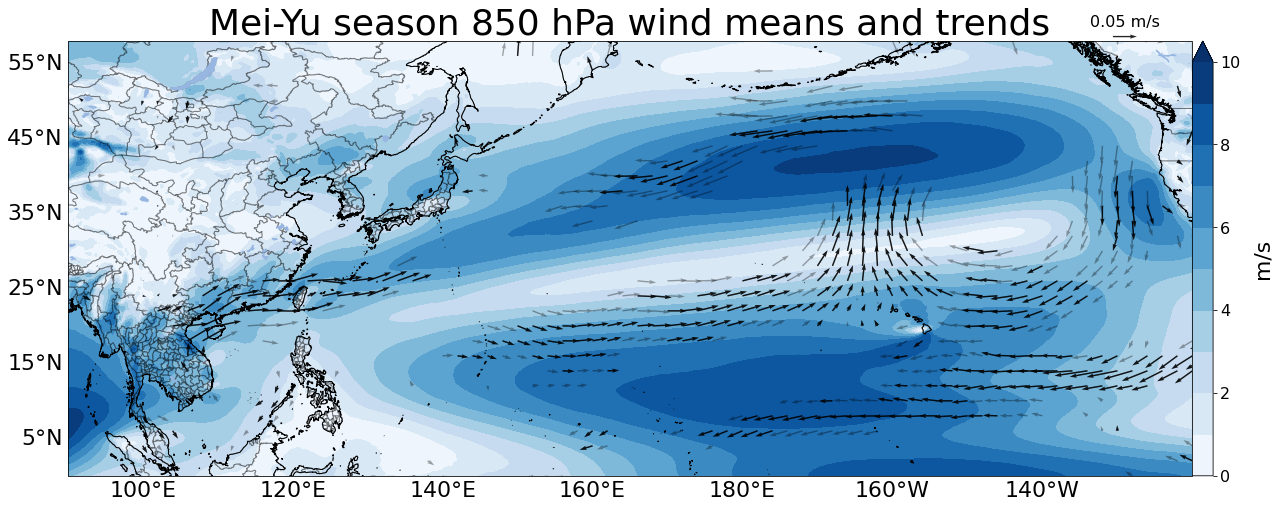

In [46]:
proj_map = ccrs.PlateCarree(central_longitude=180)
fig = plt.figure(figsize=(24,8))
ax=plt.subplot(1,1,1,projection=proj_map)

first=slopes_array_slp[:,0]
last=slopes_array_slp[:,-1]

slopes_array_first=slopes_array_slp[:,-400:]
slopes_array_second=slopes_array_slp[:,0:400]
slopes_array_second['longitude']=slopes_array_second.longitude.values+360.
slopes_array_zombie=xr.concat([slopes_array_first,slopes_array_second],dim='longitude')

cax=ax.contourf(array_zombie_wind.longitude,array_zombie_wind.latitude,array_zombie_wind,transform=ccrs.PlateCarree(),levels=np.arange(0,11,1),extend='max',cmap=plt.cm.Blues)
cbar=plt.colorbar(cax,pad=0,fraction=0.042)
cbar.ax.tick_params(labelsize=22) 
cbar.set_label('m/s',fontsize=22,rotation=90,labelpad=12)
cbar.ax.tick_params(labelsize=20)  
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.STATES.with_scale('10m'),alpha=0.3)
ax.add_feature(cfeature.LAKES.with_scale('50m'))
countries = cfeature.NaturalEarthFeature(category='cultural',name='admin_0_boundary_lines_land',scale='50m',facecolor='none')
ax.add_feature(countries)
    
latmin=0
latmax=40
lonmin=90
lonmax=200
print((lonmin,lonmax))
print((latmin,latmax))
#ax.set_xlim(lonmin,lonmax)
#ax.set_ylim(latmin,latmax)
#ax.set_extent([90,-120,0,40])
ax.set_extent([90, 240, 0, 58], crs=ccrs.PlateCarree())
ax.set_title('Mei-Yu season 850 hPa wind means and trends',fontsize=36)

Y=5
X=8
if 1==0:
    for i in range(int(slopes_array_slp.longitude.size/Y)):
        for j in range(int(slopes_array_slp.latitude.size/Y)):
            if sigs_array_slp[Y*j,Y*i]==1:
                ax.plot(slopes_array_slp.longitude.values[Y*i],slopes_array_slp.latitude.values[Y*j],transform=ccrs.PlateCarree(),marker='o',color='w',mew=1.75,markersize=6,markerfacecolor="None")
            else:
                if sigs_array_slp_10[Y*j,Y*i]==1:
                    if slopes_array_slp[Y*j,Y*i]>0:
                        ax.plot(slopes_array_slp.longitude.values[Y*i],slopes_array_slp.latitude.values[Y*j],transform=ccrs.PlateCarree(),marker='o',color='w',mew=0.5,markersize=6,markerfacecolor="None")
                    if slopes_array_slp[Y*j,Y*i]<0:
                        ax.plot(slopes_array_slp.longitude.values[Y*i],slopes_array_slp.latitude.values[Y*j],transform=ccrs.PlateCarree(),marker='o',color='w',mew=0.5,markersize=6,markerfacecolor="None")

                        
#c=ax.contour(array_zombie.longitude,array_zombie.latitude,array_zombie,transform=ccrs.PlateCarree(),levels=np.arange(992,1032,2),colors='k',linewidths=0.5,alpha=0.5)
#plt.clabel(c,fmt='%.00f',fontsize=15)

sig_xy=sigs_array_u+sigs_array_v
sig_xy10=sigs_array_u_10+sigs_array_v_10
slopes_array_u_select=slopes_array_u.where(sig_xy>0)
slopes_array_v_select=slopes_array_v.where(sig_xy>0)

slopes_array_u_select10=slopes_array_u.where(sig_xy10>0)
slopes_array_v_select10=slopes_array_v.where(sig_xy10>0)

q0=ax.quiver(u1.longitude[0::X].values,u1.latitude[0::X].values,slopes_array_u_select10[0::X,0::X].values,slopes_array_v_select10[0::X,0::X].values,transform=ccrs.PlateCarree(),units='inches',scale=0.15,width=0.019,alpha=0.35)
q=ax.quiver(u1.longitude[0::X].values,u1.latitude[0::X].values,slopes_array_u_select[0::X,0::X].values,slopes_array_v_select[0::X,0::X].values,transform=ccrs.PlateCarree(),units='inches',scale=0.15,width=0.019,alpha=0.85)
ax.quiverkey(q,0.94,1.01,0.05,'0.05 m/s',fontproperties={'size':16})



xticks = [100,120,140,160,180,-160,-140,-120]
yticks = [5, 15, 25, 35, 45, 55]
ax.tick_params(labelsize=22)

g1=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1.5,color='gray',alpha=0.0,linestyle='--')
cbar.ax.tick_params(labelsize=16) 
g1.xlabel_style={'size':22,'color':'k'}
g1.ylabel_style={'size':22,'color':'k'}
g1.xformatter=LONGITUDE_FORMATTER
g1.yformatter=LATITUDE_FORMATTER
g1.xlocator = mticker.FixedLocator(xticks)
g1.ylocator = mticker.FixedLocator(yticks)
g1.top_labels=False
g1.right_labels=False

#ax.text(lonmax+15,clat,'mm/day',ha='right',va='center',rotation=270,fontsize=14)


plt.show()

In [47]:
fig.savefig(dir+'taiwan_large_scale_composites_trends_2.png')

In [27]:
print(slopes_array_q.max().values)

6.127416e-05


(90, 200)
(0, 40)


/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


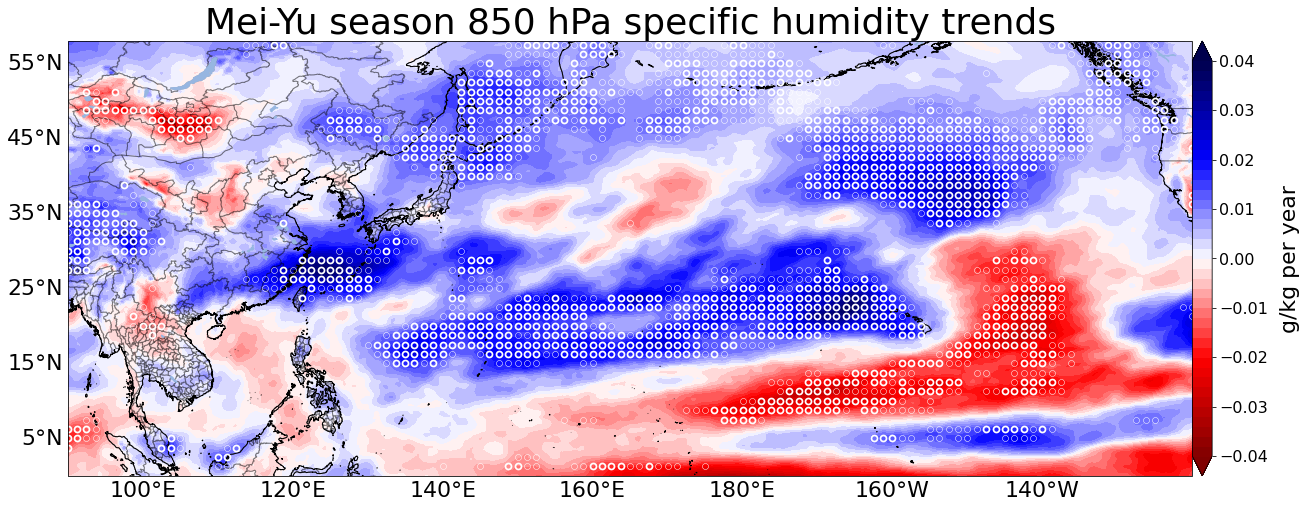

In [44]:
proj_map = ccrs.PlateCarree(central_longitude=180)
fig = plt.figure(figsize=(24,8))
ax=plt.subplot(1,1,1,projection=proj_map)

first=slopes_array_q[:,0]
last=slopes_array_q[:,-1]

slopes_array_first=slopes_array_q[:,-400:]
slopes_array_second=slopes_array_q[:,0:400]
slopes_array_second['longitude']=slopes_array_second.longitude.values+360.
slopes_array_zombie=xr.concat([slopes_array_first,slopes_array_second],dim='longitude')

cax=ax.contourf(slopes_array_zombie.longitude,slopes_array_zombie.latitude,slopes_array_zombie*1000.,transform=ccrs.PlateCarree(),levels=np.arange(-0.04,0.042,0.002),extend='both',cmap=plt.cm.seismic_r)
cbar=plt.colorbar(cax,pad=0,fraction=0.042)
cbar.ax.tick_params(labelsize=22) 
cbar.set_label('g/kg per year',fontsize=22,rotation=90,labelpad=12)
cbar.ax.tick_params(labelsize=20)  
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.STATES.with_scale('10m'),alpha=0.3)
ax.add_feature(cfeature.LAKES.with_scale('50m'))
countries = cfeature.NaturalEarthFeature(category='cultural',name='admin_0_boundary_lines_land',scale='50m',facecolor='none')
ax.add_feature(countries)
    
latmin=0
latmax=40
lonmin=90
lonmax=200
print((lonmin,lonmax))
print((latmin,latmax))
#ax.set_xlim(lonmin,lonmax)
#ax.set_ylim(latmin,latmax)
#ax.set_extent([90,-120,0,40])
ax.set_extent([90, 240, 0, 58], crs=ccrs.PlateCarree())
ax.set_title('Mei-Yu season 850 hPa specific humidity trends',fontsize=36)

Y=5
X=8
if 1==1:
    for i in range(int(slopes_array_q.longitude.size/Y)):
        for j in range(int(slopes_array_q.latitude.size/Y)):
            if sigs_array_q[Y*j,Y*i]==1:
                ax.plot(slopes_array_q.longitude.values[Y*i],slopes_array_q.latitude.values[Y*j],transform=ccrs.PlateCarree(),marker='o',color='w',mew=1.75,markersize=6,markerfacecolor="None")
            else:
                if sigs_array_q_10[Y*j,Y*i]==1:
                    if slopes_array_q[Y*j,Y*i]>0:
                        ax.plot(slopes_array_q.longitude.values[Y*i],slopes_array_q.latitude.values[Y*j],transform=ccrs.PlateCarree(),marker='o',color='w',mew=0.5,markersize=6,markerfacecolor="None")
                    if slopes_array_q[Y*j,Y*i]<0:
                        ax.plot(slopes_array_q.longitude.values[Y*i],slopes_array_q.latitude.values[Y*j],transform=ccrs.PlateCarree(),marker='o',color='w',mew=0.5,markersize=6,markerfacecolor="None")

                        
c=ax.contour(mslp_mean_all.longitude,mslp_mean_all.latitude,mslp_mean_all,levels=np.arange(992,1032,2),colors='k',linewidths=0.5,alpha=0.5)
plt.clabel(c,fmt='%.00f',fontsize=15)

if 1==0:
    sig_xy=sigs_array_ivtx+sigs_array_ivty
    sig_xy10=sigs_array_ivtx_10+sigs_array_ivty_10
    slopes_array_ivtx_select=slopes_array_ivtx.where(sig_xy>0)
    slopes_array_ivty_select=slopes_array_ivty.where(sig_xy>0)

    slopes_array_ivtx_select10=slopes_array_ivtx.where(sig_xy10>0)
    slopes_array_ivty_select10=slopes_array_ivty.where(sig_xy10>0)

    q0=ax.quiver(ivtx.longitude[0::X].values,ivtx.latitude[0::X].values,slopes_array_ivtx_select10[0::X,0::X].values,slopes_array_ivty_select10[0::X,0::X].values,transform=ccrs.PlateCarree(),units='inches',scale=4,width=0.019,alpha=0.35)
    q=ax.quiver(ivtx.longitude[0::X].values,ivtx.latitude[0::X].values,slopes_array_ivtx_select[0::X,0::X].values,slopes_array_ivty_select[0::X,0::X].values,transform=ccrs.PlateCarree(),units='inches',scale=4,width=0.019,alpha=0.85)
    ax.quiverkey(q,0.94,1.01,1,'1 kg/m/s',fontproperties={'size':16})



xticks = [100,120,140,160,180,-160,-140,-120]
yticks = [5, 15, 25, 35, 45, 55]
ax.tick_params(labelsize=22)

g1=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1.5,color='gray',alpha=0.0,linestyle='--')
cbar.ax.tick_params(labelsize=16) 
g1.xlabel_style={'size':22,'color':'k'}
g1.ylabel_style={'size':22,'color':'k'}
g1.xformatter=LONGITUDE_FORMATTER
g1.yformatter=LATITUDE_FORMATTER
g1.xlocator = mticker.FixedLocator(xticks)
g1.ylocator = mticker.FixedLocator(yticks)
g1.top_labels=False
g1.right_labels=False

#ax.text(lonmax+15,clat,'mm/day',ha='right',va='center',rotation=270,fontsize=14)


plt.show()

In [45]:
fig.savefig(dir+'taiwan_large_scale_composites_trends_3.png')

In [57]:
fig.savefig(dir+'neusa_large_scale_composites_trends_4.png')

In [ ]:
mslp_mean_all=slp_annual_means.mean(dim='time',skipna=True)
print(mslp_mean_all)
print(u_annual_means)
print(slopes_array)

(90, 200)
(0, 40)


/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1841: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1841: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


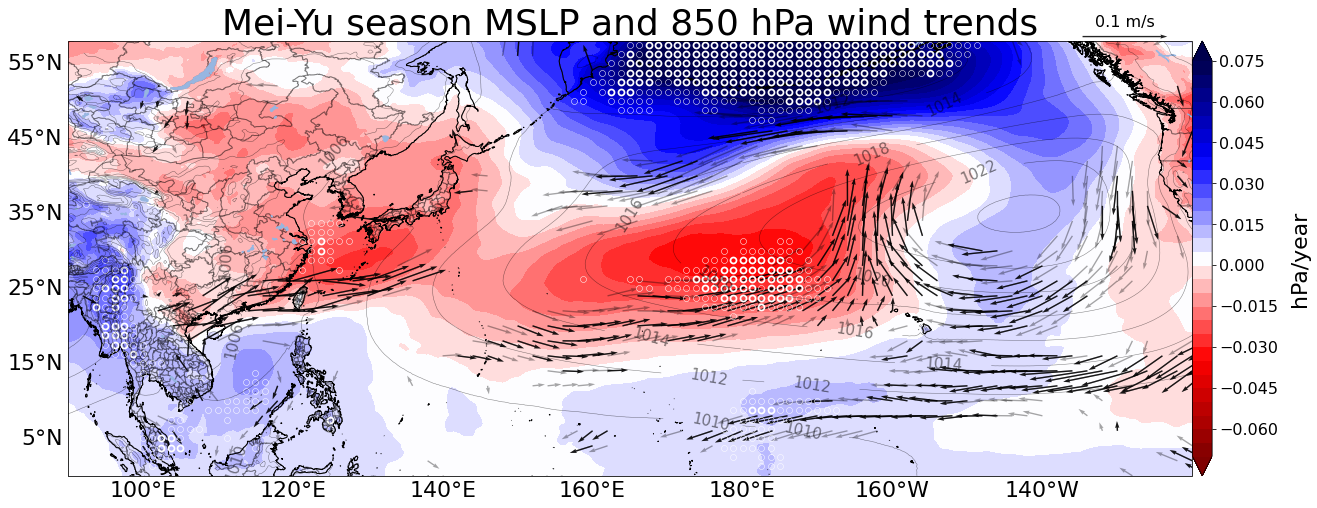

In [58]:
proj_map = ccrs.PlateCarree(central_longitude=180)
fig = plt.figure(figsize=(24,8))
ax=plt.subplot(1,1,1,projection=proj_map)

slopes_array_first=slopes_array[:,-400:]
slopes_array_second=slopes_array[:,0:400]
slopes_array_second['longitude']=slopes_array_second.longitude.values+360.
slopes_array_zombie=xr.concat([slopes_array_first,slopes_array_second],dim='longitude')

mslp_first=mslp_mean_all[:,-400:]
mslp_second=mslp_mean_all[:,0:400]
mslp_second['longitude']=mslp_second.longitude.values+360.

mslp_zombie=xr.concat([mslp_first,mslp_second],dim='longitude')
cax=ax.contourf(slopes_array_zombie.longitude,slopes_array_zombie.latitude,slopes_array_zombie,transform=ccrs.PlateCarree(),levels=np.arange(-0.07,0.075,0.005),extend='both',cmap=plt.cm.seismic_r)
cbar=plt.colorbar(cax,pad=0,fraction=0.042)

c=ax.contour(mslp_mean_all.longitude,mslp_mean_all.latitude,mslp_mean_all,levels=np.arange(992,1032,2),transform=ccrs.PlateCarree(),colors='k',linewidths=0.5,alpha=0.5,zorder=25)
plt.clabel(c,fmt='%.00f',fontsize=15)

cbar.set_label('hPa/year',fontsize=22,rotation=90,labelpad=12)
cbar.ax.tick_params(labelsize=20)  
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.STATES.with_scale('10m'),alpha=0.3)
ax.add_feature(cfeature.LAKES.with_scale('50m'))
countries = cfeature.NaturalEarthFeature(category='cultural',name='admin_0_boundary_lines_land',scale='50m',facecolor='none')
ax.add_feature(countries)
    
latmin=0
latmax=40
lonmin=90
lonmax=200
print((lonmin,lonmax))
print((latmin,latmax))
#ax.set_xlim(lonmin,lonmax)
#ax.set_ylim(latmin,latmax)
#ax.set_extent([90,-120,0,40])
ax.set_extent([90, 240, 0, 58], crs=ccrs.PlateCarree())


ax.set_title('Mei-Yu season MSLP and 850 hPa wind trends',fontsize=36)

Y=5
X=8
if 1==1:
    for i in range(int(slopes_array.longitude.size/Y)):
        for j in range(int(slopes_array.latitude.size/Y)):
            if sigs_array[Y*j,Y*i]==1:
                ax.plot(slopes_array.longitude.values[Y*i],slopes_array.latitude.values[Y*j],transform=ccrs.PlateCarree(),marker='o',color='w',mew=1.75,markersize=6,markerfacecolor="None")
            else:
                if sigs_array_10[Y*j,Y*i]==1:
                    if slopes_array[Y*j,Y*i]>0:
                        ax.plot(slopes_array.longitude.values[Y*i],slopes_array.latitude.values[Y*j],transform=ccrs.PlateCarree(),marker='o',color='w',mew=0.5,markersize=6,markerfacecolor="None")
                    if slopes_array[Y*j,Y*i]<0:
                        ax.plot(slopes_array.longitude.values[Y*i],slopes_array.latitude.values[Y*j],transform=ccrs.PlateCarree(),marker='o',color='w',mew=0.5,markersize=6,markerfacecolor="None")

xticks = [100,120,140,160,180,-160,-140,-120]
yticks = [5, 15, 25, 35, 45, 55]
ax.tick_params(labelsize=22)

sig_uv=sigs_array_u+sigs_array_v
sig_uv10=sigs_array_u_10+sigs_array_v_10
slopes_array_u_select=slopes_array_u.where(sig_uv>0)
slopes_array_v_select=slopes_array_v.where(sig_uv>0)

slopes_array_u_select10=slopes_array_u.where(sig_uv10>0)
slopes_array_v_select10=slopes_array_v.where(sig_uv10>0)

q0=ax.quiver(u1.longitude[0::X].values,u1.latitude[0::X].values,slopes_array_u_select10[0::X,0::X].values,slopes_array_v_select10[0::X,0::X].values,transform=ccrs.PlateCarree(),units='inches',scale=0.085,width=0.019,alpha=0.35)
q=ax.quiver(u1.longitude[0::X].values,u1.latitude[0::X].values,slopes_array_u_select[0::X,0::X].values,slopes_array_v_select[0::X,0::X].values,transform=ccrs.PlateCarree(),units='inches',scale=0.085,width=0.019,alpha=0.85)
ax.quiverkey(q,0.94,1.01,0.1,'0.1 m/s',fontproperties={'size':16})

g1=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1.5,color='gray',alpha=0.0,linestyle='--')
cbar.ax.tick_params(labelsize=16) 
g1.xlabel_style={'size':22,'color':'k'}
g1.ylabel_style={'size':22,'color':'k'}
g1.xformatter=LONGITUDE_FORMATTER
g1.yformatter=LATITUDE_FORMATTER
g1.xlocator = mticker.FixedLocator(xticks)
g1.ylocator = mticker.FixedLocator(yticks)
g1.top_labels=False
g1.right_labels=False

#ax.text(lonmax+15,clat,'mm/day',ha='right',va='center',rotation=270,fontsize=14)


plt.show()



In [59]:
fig.savefig(dir+'taiwan_large_scale_composites_trends_5.png')